In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
pd.set_option('max_rows', 7)
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 4

In [3]:
data = loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [4]:
X = data['X']
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
y = data['y']
y

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

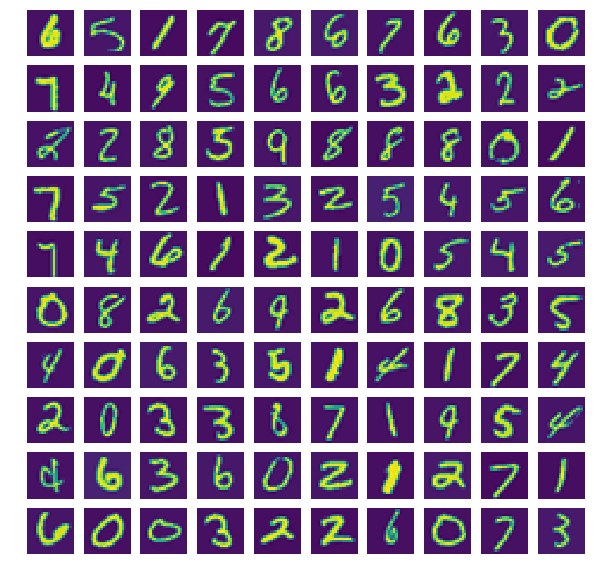

In [6]:
FIG_SIZE = 10
_, axarr = plt.subplots(FIG_SIZE, FIG_SIZE, figsize=(FIG_SIZE, FIG_SIZE))
for i in range(FIG_SIZE):
    for j in range(FIG_SIZE):
        random_digit = X[np.random.randint(X.shape[0])]
        axarr[i, j].imshow(random_digit.reshape((20, 20), order='F'))
        axarr[i, j].axis('off')

In [7]:
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print(f"Theta shapes: theta1={theta1.shape}, theta2={theta2.shape}")

Theta shapes: theta1=(25, 401), theta2=(10, 26)


In [8]:
#unroll params
#ravel "F"- flatten thetas in column-major
nn_params = np.hstack((theta1.ravel(order='F'), 
                       theta2.ravel(order='F')))
nn_params

array([-0.02256239, -0.09838113,  0.11615605, ..., -2.11014003,
       -2.1319153 , -1.32752042])

In [9]:
m, n = X.shape
ones = np.ones((m, 1))
m

5000

In [10]:
#neural network hyperparameters
input_layer_size = 400
hidden_layer_size = 25
num_of_labels = 10
lmbda = 1

In [11]:
#one hot encoding
y_dummies = pd.get_dummies(y.flatten())
y_dummies

,1,2,3,4,5,6,7,8,9,10
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
4997,0,0,0,0,0,0,0,0,1,0
4998,0,0,0,0,0,0,0,0,1,0
4999,0,0,0,0,0,0,0,0,1,0


In [25]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [54]:
def nnCostFunction():
    theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)],
                    (hidden_layer_size, input_layer_size+1), 'F')
    theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):],
                        (num_of_labels, hidden_layer_size+1), 'F')

    a1 = np.hstack((ones, X))
    a2 = sigmoid(a1 @ theta1.T)
    a2 = np.hstack((ones, a2))
    h = sigmoid(a2 @ theta2.T)

    inner_sum1 = np.multiply(y_dummies, np.log(h))
    inner_sum2 = np.multiply(1-y_dummies, np.log(1-h))
    inner_sums = np.sum(inner_sum1 + inner_sum2)

    reg_sum1 = np.sum(np.sum(np.power(theta1[:,1:], 2), axis=1))
    reg_sum2 = np.sum(np.sum(np.power(theta2[:,1:], 2), axis=1))
    reg_sums = reg_sum1 + reg_sum2

    regularization = (lmbda/(2*m)) * reg_sums
    J = np.sum(inner_sums/(-m)) + regularization

    return J


#expected 0.383770
nnCostFunction()

0.38376985909092354

True